# Timeseries

In [1]:
import os
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from viz import local
viz = local.VizNotebook()

In [2]:
features = pd.read_csv('data/F2005.csv')
features = features[(features['category'] == 'assault') & (features['year'] >= 2005)]
features.head()

,category,city,zip,year,month,day,weekday,hour,longitude,latitude,gang_related,aggravated,incident_date,gun,shooting,knife,carjacking,kidnapping,violent
2,assault,valencia,91354,2005,1,1,5,1.166667,-118.559219,34.467958,0,0,2005-01-01,0,0,0,0,0,1
5,assault,los angeles,90012,2005,1,1,5,6.166667,-118.231158,34.059131,0,0,2005-01-01,0,0,0,0,0,1
6,assault,los angeles,90012,2005,1,1,5,10.166667,-118.231158,34.059131,0,0,2005-01-01,0,0,0,0,0,1
7,assault,san gabriel,91776,2005,1,1,5,1.000000,-118.073508,34.097008,0,1,2005-01-01,0,0,0,0,0,1
8,assault,los angeles,90012,2005,1,1,5,11.750000,-118.231158,34.059131,0,0,2005-01-01,0,0,0,0,0,1


In [3]:
for year in range(2006, 2016):
    df = pd.read_csv('data/F{}.csv'.format(year))
    df = df[(df['category'] == 'assault') & (df['year'] >= 2005)]
    features = features.append(df, ignore_index = True)

features.shape

(228336, 19)

In [4]:
timeseries = features\
    .groupby(['incident_date','aggravated']).size()\
    .reset_index(name = 'total')

In [5]:
timeseries['date'] = timeseries['incident_date'].apply(lambda x: str(x))
timeseries['aggravated'] = timeseries['aggravated'].apply(lambda x: str(x))

viz.static(timeseries.to_json(orient='records'), type = 'line', height = 350, width = '100%',
           x = 'date',
           y = 'total',
           z = 'aggravated',
           labels = ['Non-Aggravated','Aggravated'],
           colormap = {'0':'maroon', '1':'red'},
           title = 'Daily Total Assault Incidents 2005 - 2016 Timeline')

The data looks very noisy. Both components show very similar seasonal pattern, but different trend overall.

#### Signal vs. Noise

In [5]:
import scipy.signal as signal

In [6]:
# design the Buterworth filter
N  = 2   # order
Wn = 0.1 # cutoff
B, A = signal.butter(N, Wn, output = 'ba')

timeseries = features[features['aggravated'] == 0].groupby(['incident_date'], as_index = True).size()
timeseries.index = pd.to_datetime(timeseries.index)
filtered = pd.Series(signal.filtfilt(B, A, timeseries), index = timeseries.index)
timeseries.head()

incident_date
2005-01-01    63
2005-01-02    36
2005-01-03    30
2005-01-04    22
2005-01-05    31
dtype: int64

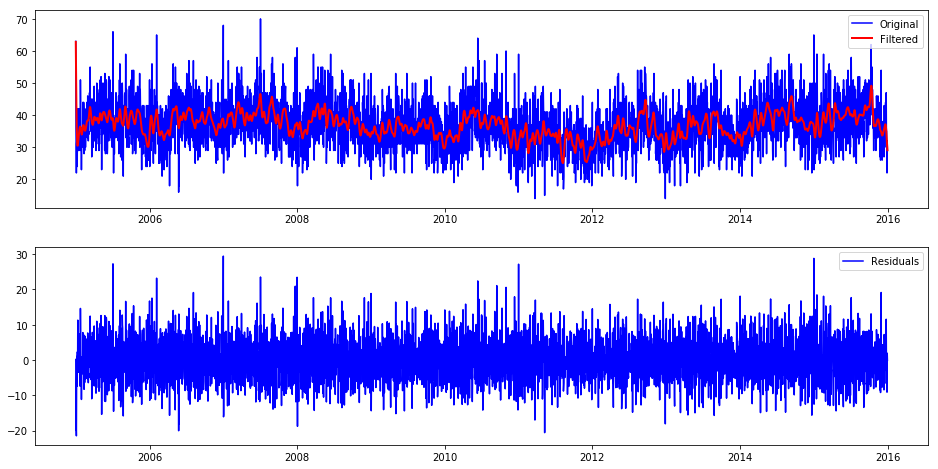

In [7]:
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(211)
plt.plot(timeseries, 'b-')
plt.plot(filtered, 'r-', linewidth = 2)
plt.legend(['Original','Filtered'])
 
ax1 = fig.add_subplot(212)
plt.plot(timeseries - filtered, 'b-')
plt.legend(['Residuals'])
plt.show()

### 1. ARIMA Model
(Autoregressive Integrated Moving Average)

Most of the TS models work on the assumption that the TS is stationary: statistical properties such as mean and variance remain constant over time.

In [8]:
train, test = timeseries[:-90], timeseries[-90:]

In [10]:
from statsmodels.tsa.stattools import adfuller, acf, pacf

# check our timeseries as is
result = adfuller(train.values)
print('ADF Statistic: {:.6f} p-value: {:.6f} Critical: {}'.format(result[0], result[1],
        ' '.join(['{}: {:.4f}'.format(key, value) for key, value in result[4].items()])))

ADF Statistic: -5.228061 p-value: 0.000008 Critical: 1%: -3.4320 5%: -2.8623 10%: -2.5672


In [11]:
# check with year diff
stationary = (train - train.shift(365)).dropna()
result = adfuller(stationary.values)
print('ADF Statistic: {:.6f} p-value: {:.6f} Critical: {}'.format(result[0], result[1],
        ' '.join(['{}: {:.4f}'.format(key, value) for key, value in result[4].items()])))

ADF Statistic: -5.928372 p-value: 0.000000 Critical: 1%: -3.4322 5%: -2.8624 10%: -2.5672


The result of a statistical significance test of whether the differenced series is stationary (Dickey-Fuller test)
shows value smaller than the critical value at 1%. Which suggests that the time series data is stationary with 99% confidence. Year differenciation improves the confidence, lets perform complete seasonal decomposition

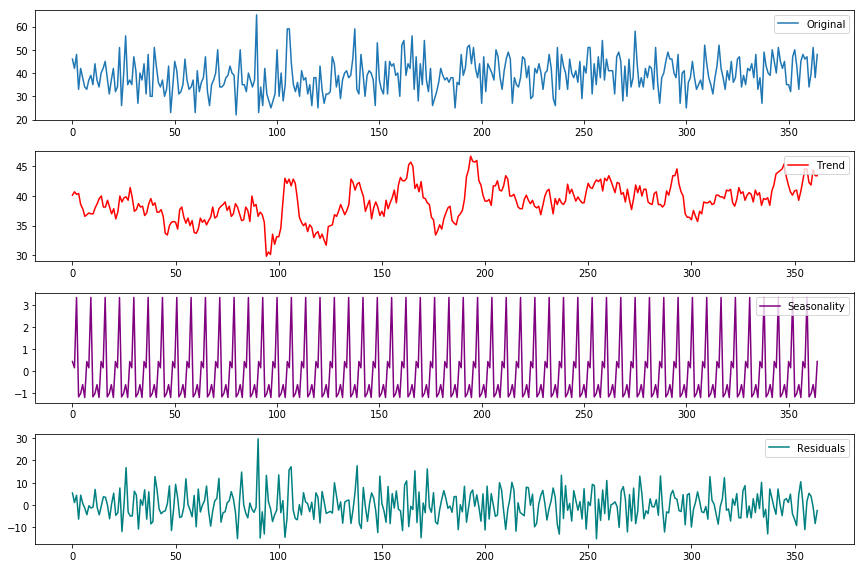

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(train)

orig = train[-365:]
d = [i for i in range(365)]

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = plt.figure(figsize=(12,8))

plt.subplot(411)
plt.plot(d, orig.values, label = 'Original')
plt.legend(loc='upper right')

plt.subplot(412)
plt.plot(d, trend[-365:].values, color = 'red', label = 'Trend')
plt.legend(loc='upper right')

plt.subplot(413)
plt.plot(d, seasonal[-365:].values, color = 'purple', label = 'Seasonality')
plt.legend(loc='upper right')

plt.subplot(414)
plt.plot(d, residual[-365:].values, color = 'teal', label = 'Residuals')
plt.legend(loc='upper right')

plt.tight_layout()

In [13]:
# decomp residual
result = adfuller(residual.dropna().values)
print('ADF Statistic: {:.6f} p-value: {:.6f} Critical: {}'.format(result[0], result[1],
        ' '.join(['{}: {:.4f}'.format(key, value) for key, value in result[4].items()])))

ADF Statistic: -22.580770 p-value: 0.000000 Critical: 1%: -3.4320 5%: -2.8623 10%: -2.5672


In [14]:
L = len(train) - len(residual.dropna())
L

6

Looks like YEARly and WEEKly are main components.

In [15]:
stationary = (train/train.shift(L)).dropna()

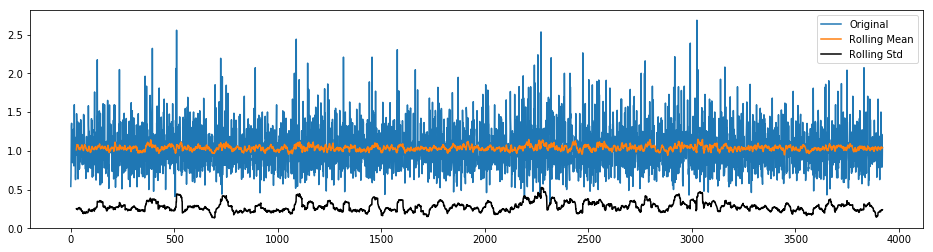

In [16]:
# rolling statistics
rolmean = stationary.rolling(window = 28, center = False).mean() 
rolstd = stationary.rolling(window = 28, center = False).std()
t = [i for i in range(len(stationary))]

fig = plt.figure(figsize=(16,4))
orig = plt.plot(t, stationary.values, label = 'Original')
mean = plt.plot(t, rolmean.values, label = 'Rolling Mean')
std = plt.plot(t, rolstd.values, color = 'black', label = 'Rolling Std')
plt.legend()
plt.show()

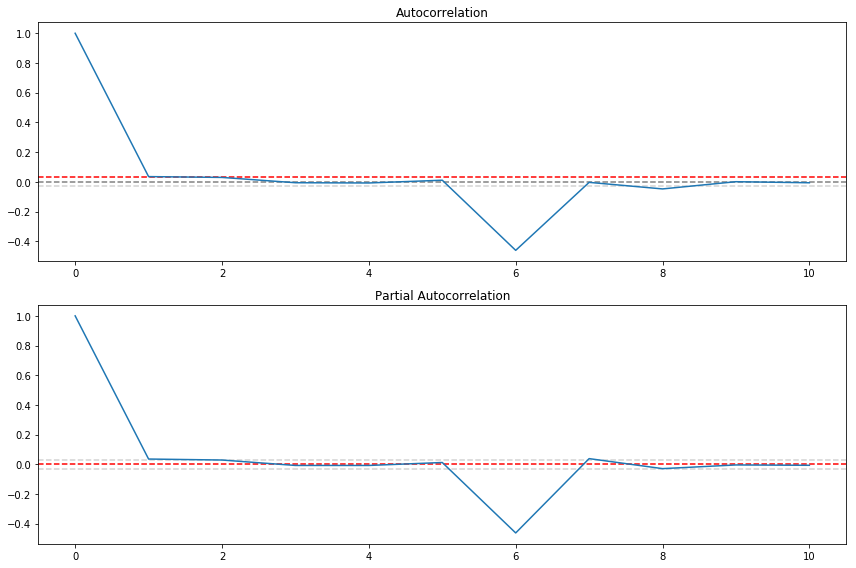

In [17]:
fig = plt.figure(figsize=(12,8))

# PACF:
plt.subplot(212)
plt.axhline(y = 0, linestyle='--',color='red')
plt.axhline(y = -1.96/np.sqrt(len(stationary)), linestyle='--', color='lightgray')
plt.axhline(y = 1.96/np.sqrt(len(stationary)), linestyle='--', color='lightgray')
plt.plot(pacf(stationary, nlags = 10, method='ols'))
plt.title('Partial Autocorrelation')

# ACF: 
plt.subplot(211) 
plt.axhline(y = 0, linestyle='--', color='gray')
plt.axhline(y = -1.96/np.sqrt(len(stationary)), linestyle='--',color='lightgray')
plt.axhline(y = 1.96/np.sqrt(len(stationary)), linestyle='--', color='red')
plt.plot(acf(stationary, nlags = 10))
plt.title('Autocorrelation')

plt.tight_layout()

Next step is to chose parameters. In the plot above, the $p$ and $q$ values can be determined as follows:
* $p$: the lag value where the PACF drops to 0 for the first time
* $q$: the lag value where the ACF chart crosses the upper confidence interval for the first time

In [18]:
from statsmodels.tsa.arima_model import ARIMA

def show_results(data, order, title, n = 0):
    fig = plt.figure(figsize=(12,4))

    model = ARIMA(data, order = order)  
    res = model.fit(disp = -1)  
    d = len(data.values)-len(res.fittedvalues.values)
    t = [i for i in range(len(res.fittedvalues))]

    plt.plot(t[n:], data[d:].values[n:], label = 'original')
    plt.plot(t[n:], res.fittedvalues[n:] + 1, color = 'red', label = 'predicted')
    
    plt.title('{} RSS: {}'.format(title, sum((res.fittedvalues.values + 1 - data[d:].values)**2)))
    plt.legend()
    plt.show()
    
    return res.fittedvalues.copy()

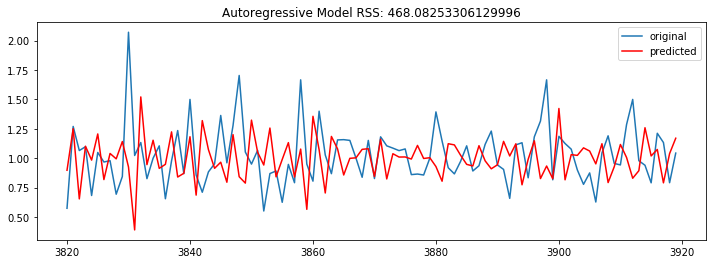

In [19]:
pred_AR = show_results(stationary, (1, 1, 0), 'Autoregressive Model', n = -100)

In [20]:
pred_AR.head()

incident_date
2005-01-08    0.000096
2005-01-09   -0.062989
2005-01-10   -0.215298
2005-01-11   -0.108330
2005-01-12   -0.018080
dtype: float64

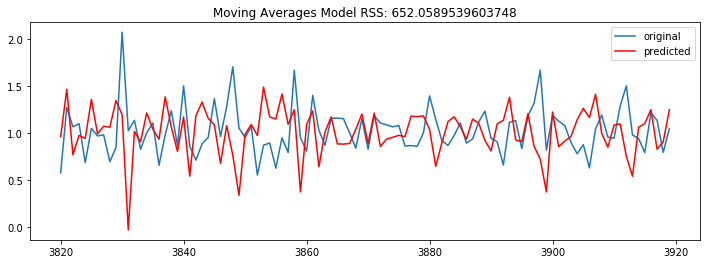

In [21]:
pred_MA = show_results(stationary, (0, 1, 1), 'Moving Averages Model', n = -100)

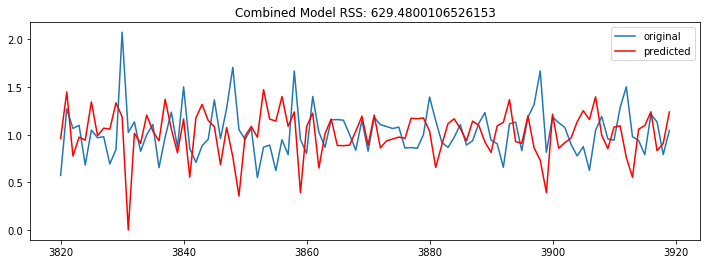

In [22]:
pred_ARMA = show_results(stationary, (1, 1, 1), 'Combined Model', n = -100)

In [23]:
history = [float(t) for t in train]
prediction = []

# using Autoregressive which has lesser error
for d in range(len(test)):
    model = ARIMA(history, order = (1, 1, 0))
    fit = model.fit(disp = 0)
    prediction.append(float(fit.forecast()[0]))
    history.append(test[d])

error = np.sqrt(sum((test - prediction)**2))/len(test)
print('Error: {:.4f}'.format(error))

arima_prediction = pd.Series(prediction, index = test.index)

Error: 0.7244


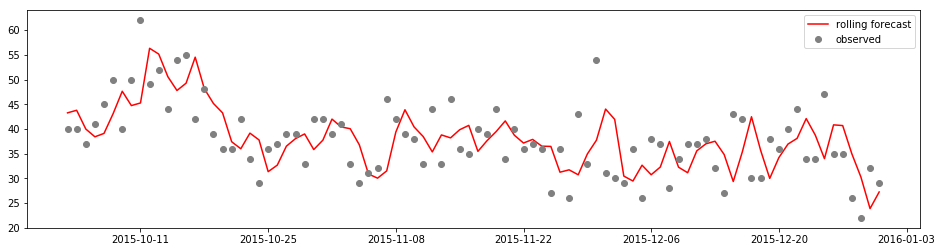

In [24]:
fig = plt.figure(figsize=(16,4))
plt.plot(arima_prediction, color = 'red', label = 'rolling forecast')
plt.plot(test, 'o', color = 'gray', label = 'observed')
plt.legend(loc = 'upper right')
plt.show()

### 2. LSTM Model

In [ ]:
import tensorflow as tf

In [26]:
tf.reset_default_graph()

In [27]:
# network parameters
n_steps = 6
n_inputs = 1
n_neurons = 6
n_layers = 2
n_outputs = 1
n_iterations = 16000
batch_size = 1
learning_rate = 0.0001

In [28]:
# standartization
M = train.mean()
S = train.std()
T = ((train - M)/S).as_matrix()
T

array([ 3.54784549, -0.11796534, -0.93258996, ...,  1.91859624,
        0.15357621,  1.51128392])

In [29]:
# generate batches
def next_batch(n_steps, batch_size):
    size = n_steps * batch_size
    start = np.random.randint(0, T.shape[0] - size)
    x = T[start:start + size].reshape((batch_size, n_steps, 1))
    y = T[start + 1:start + size + 1].reshape((batch_size, n_steps, 1))
    return x, y

In [30]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
Y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [31]:
# network architecture
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(num_units = n_neurons, activation = tf.nn.relu)
                                 for layer in range(n_layers)]),
    output_size = n_outputs)

outputs, states = tf.nn.dynamic_rnn(cell, X, dtype = tf.float32)

In [32]:
loss = tf.reduce_mean(tf.square(outputs - Y))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
opt = optimizer.minimize(loss)

In [33]:
init = tf.global_variables_initializer()

In [34]:
saver = tf.train.Saver()

In [35]:
with tf.Session() as sess:
    sess.run(init)
    
    for i in range(n_iterations):
        X_batch, Y_batch = next_batch(n_steps, batch_size)
        sess.run(opt, feed_dict = { X: X_batch, Y: Y_batch })
        
        if i % 1000 == 0:
            print('Iteration: {:<8} MSE: {:.4f}'.format(i, loss.eval(feed_dict = { X: X_batch, Y: Y_batch })))

    print('Iteration: {:<8} MSE: {:.4f}'.format(i, loss.eval(feed_dict = { X: X_batch, Y: Y_batch })))
    saver.save(sess, './rnn_model')


Iteration: 0        MSE: 0.8830
Iteration: 1000     MSE: 1.4060
Iteration: 2000     MSE: 2.1346
Iteration: 3000     MSE: 0.2665
Iteration: 4000     MSE: 1.0567
Iteration: 5000     MSE: 0.9525
Iteration: 6000     MSE: 1.6659
Iteration: 7000     MSE: 1.7073
Iteration: 8000     MSE: 1.8675
Iteration: 9000     MSE: 1.3467
Iteration: 10000    MSE: 1.4479
Iteration: 11000    MSE: 0.5534
Iteration: 12000    MSE: 0.5914
Iteration: 13000    MSE: 0.5845
Iteration: 14000    MSE: 0.4407
Iteration: 15000    MSE: 0.7857
Iteration: 15999    MSE: 0.6772


In [36]:
t = ((timeseries[-(len(test) + n_steps):] - M)/S).as_matrix()

with tf.Session() as sess:
    saver.restore(sess, './rnn_model')

    prediction = []
    for i in range(len(test)):
        X_test = t[i:i + n_steps].reshape((1, n_steps, 1))
        Y_pred = sess.run(outputs, feed_dict = {X: X_test})
        prediction.append(Y_pred.flatten()[-1] * S + M)
        
error = np.sqrt(sum((test - prediction)**2))/len(test)
print('Error: {:.4f}'.format(error))
rnn_prediction = pd.Series(prediction, index = test.index)

INFO:tensorflow:Restoring parameters from ./rnn_model
Error: 0.6886


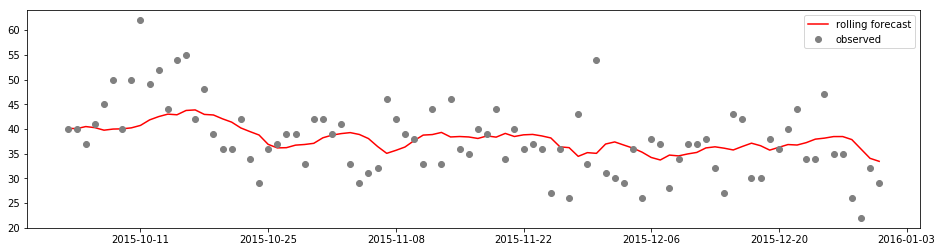

In [37]:
fig = plt.figure(figsize=(16,4))
plt.plot(rnn_prediction, color = 'red', label = 'rolling forecast')
plt.plot(test, 'o', color = 'gray', label = 'observed')
plt.legend(loc = 'upper right')
plt.show()